# [Extreme Gradient Boosting with `xgboost`](https://www.datacamp.com/completed/statement-of-accomplishment/course/743be833af058b805986e094e92a852fe43a1960)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/datacamp/blob/main/notebooks/courses/extreme_gradient_boosting_with_xgboost/notebook.ipynb)
[![Render nbviewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/datacamp/blob/main/notebooks/courses/extreme_gradient_boosting_with_xgboost/notebook.ipynb)

**Contents**
- [Classification](#Classification)
- [Regression](#Regression)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Pipelines](#Pipelines)


In [1]:
# fmt: off
%matplotlib inline

import dtreeviz  # brew install graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_breast_cancer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn_pandas import DataFrameMapper

ames_housing = pd.read_csv("ames_housing.csv")  # kaggle.com/c/house-prices-advanced-regression-techniques
breast_cancer = load_breast_cancer()            # archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
churn = pd.read_csv("churn.csv")
kidney_disease = pd.read_csv(
    "kidney_disease.csv",                       # archive.ics.uci.edu/dataset/336/chronic+kidney+disease
    na_values="?",
)
# fmt: on


## Classification

The supervised learning task of predicting a label (or class) from features is known as a _classification_ problem. This type of machine learning requires labeled data unlike its unsupervised counterpart. In other words, if you wanted to train a model to classify dogs and cats, you would need to show it pictures of dogs and cats labeled as such. Other supervised learning problems include ranking and recommendation.

Features can be numeric or categorical. Numeric features are typically scaled (Z-scored) to have a mean of 0 and a standard deviation of 1; categorical features are typically one-hot encoded.

Predicting a binary outcome (yes or no) is _binary classification_, and predicting multiple classes (e.g., dog, cat, or mouse) is _multi-class classification_.

For evaluating classification models, AUC or _area under the curve_ is a common metric for binary problems. It is the area under the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve and is a measure of how well a model can distinguish between two classes. For multi-class problems, accuracy and the confusion matrix are common evaluation metrics.

Common algorithms for classification problems are logistic regression and decision trees (and their ensembles).

<img src="./ibm-decision-tree.jpg" width="600" />

> _Source: [IBM](https://www.ibm.com/topics/decision-trees)_

### XGBoost

_XGBoost_ is a distributed gradient boosting library that started as a research project at the University of Washington ([Chen & Guestrin](https://arxiv.org/abs/1603.02754), 2016). It was originally written in C++ and now has bindings for many languages like Python.

Because the core algorithm is parallelizable, it can take advantage of multi-core processors, GPUs, and even distributed clusters of servers. Another benefit of XGBoost is the use of both L1 (Lasso) and L2 (Ridge) regularization, which reduces overfitting compared to traditional gradient boosting trees.

XGBoost has a [`sklearn` API](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html) in addition to the native "Learning" API. The former allows interoperability with the Scikit-learn ecosystem (e.g., pipelines, cross-validation). The native API allows for more control during training and also requires the use of the `DMatrix` optimized data structure.

XGBoost is a great choice for most supervised classification, regression, and ranking tasks. It can handle large datasets as long as they fit into memory and the number of features does not exceed the number of examples. It is **not** the best algorithm for common deep learning tasks like computer vision and natural language processing.

Other gradient boosting libraries include Microsoft's [LightGBM](https://github.com/microsoft/LightGBM), Yandex's [CatBoost](https://github.com/catboost/catboost), and Stanford's [NGBoost](https://github.com/stanfordmlgroup/ngboost).

In [2]:
# take all columns except last
# with fancy indexing the first value is for *rows*
churn_X = churn.iloc[:, :-1]

# take only last column (`month_5_still_here`)
churn_y = churn.iloc[:, -1]

# splits
X_train, X_test, y_train, y_test = train_test_split(
    churn_X,
    churn_y,
    test_size=0.2,
    random_state=42,
)

# fit
model = xgb.XGBClassifier(n_estimators=10, objective="binary:logistic", seed=42)
model.fit(X_train, y_train)

# score
preds = model.predict(X_test)
accuracy = float(np.sum(preds == y_test)) / y_test.shape[0]
print(f"accuracy: {accuracy:.4f}")


accuracy: 0.7420


In [3]:
churn_X, churn_y = churn.iloc[:, :-1], churn.iloc[:, -1]

# create dmatrix
churn_DM = xgb.DMatrix(data=churn_X, label=churn_y)

# 3-fold cross validation
params = {"objective": "reg:logistic", "max_depth": 3}
cv_results = xgb.cv(
    dtrain=churn_DM,
    params=params,
    nfold=3,
    num_boost_round=5,
    metrics="error",
    as_pandas=True,
    seed=42,
)
cv_results


,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.288599,0.019146,0.293401,0.022077
1,0.268200,0.004466,0.270699,0.006047
2,0.261200,0.001059,0.263299,0.006398
3,0.253500,0.002319,0.255899,0.005485
4,0.250000,0.003876,0.254099,0.005264


In [4]:
# accuracy
accuracy = (1 - cv_results["test-error-mean"]).iloc[-1]
print(f"accuracy: {accuracy:.4f}")


accuracy: 0.7459


In [5]:
cv_results = xgb.cv(
    dtrain=churn_DM,
    params=params,
    nfold=3,
    num_boost_round=5,
    metrics="auc",
    as_pandas=True,
    seed=42,
)
cv_results


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.774726,0.004428,0.771435,0.008309
1,0.783047,0.002772,0.779101,0.008274
2,0.812443,0.003562,0.808415,0.009203
3,0.825293,0.006024,0.820156,0.006937
4,0.830254,0.004931,0.825123,0.007060


In [6]:
auc = cv_results["test-auc-mean"].iloc[-1]
print(f"auc: {auc:.4f}")


auc: 0.8251


## Regression

_Regression_ problems involve predicting a continuous value like a stock price or the temperature. Evaluating them uses a different set of tools than for classification. Two common metrics are the mean absolute error (MAE) and the root mean squared error (RMSE).

MAE is less sensitive to outliers than RMSE because it does not square the errors (which amplifies them). RMSE is more appropriate when large errors are particularly undesirable.

### Loss Functions

The _loss function_ quantifies how far off a prediction is from the actual result. In machine learning, the goal is to minimize the loss. In XGBoost, common loss functions are `reg:squarederror` for regression problems, `reg:logistic` for classification problems when you want the decision, and `binary:logistic` for classification problems when you want the probability.

The keyword argument `objective` is used to specify the loss function.

In [7]:
housing_X, housing_y = ames_housing.iloc[:, :-1], ames_housing.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    housing_X,
    housing_y,
    test_size=0.2,
    random_state=42,
)

model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=10, seed=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse:.4f}")


RMSE: 30179.8741


In [8]:
housing_train_DM = xgb.DMatrix(data=X_train, label=y_train)
housing_test_DM = xgb.DMatrix(data=X_test, label=y_test)

# use a linear base learner
params = {"booster": "gblinear", "objective": "reg:squarederror"}
xg_reg = xgb.train(params=params, dtrain=housing_train_DM, num_boost_round=5)
preds = xg_reg.predict(housing_test_DM)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse:.4f}")


RMSE: 47745.8915


In [9]:
housing_DM = xgb.DMatrix(data=housing_X, label=housing_y)
params = {"objective": "reg:squarederror", "max_depth": 4}

cv_results = xgb.cv(
    dtrain=housing_DM,
    params=params,
    nfold=4,
    num_boost_round=5,
    metrics="mae",
    as_pandas=True,
    seed=42,
)
cv_results


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,43941.624358,463.278711,44651.710124,1642.431975
1,34579.418276,223.089390,35900.724583,1313.683408
2,28216.664929,232.474094,30333.208497,1029.652252
3,23822.760939,265.596127,26689.350487,697.789856
4,20877.302287,96.176122,24472.974508,798.685106


In [10]:
mae = cv_results["test-mae-mean"].tail(1)
print(mae)


4    24472.974508
Name: test-mae-mean, dtype: float64


### Regularization

Loss functions don't just measure the difference between the actual and predicted values; they also include a penalty term that penalizes models for being too complex. This is known as _regularization_.

The goal is to find models that are as accurate and simple as they can be. There are parameters that can be tuned to control the complexity of the model. Gamma controls whether a node will split, so a higher value will lead to fewer splits. Alpha (L1 regularization) penalizes leaf weights rather than feature weights, so a higher value will lead to smaller leaf weights. Lambda (L2 regularization) is a smoother penalty than alpha, and causes leaf weights to smoothly decrease rather than being set to zero.

In [11]:
housing_X, housing_y = ames_housing.iloc[:, :-1], ames_housing.iloc[:, -1]
housing_DM = xgb.DMatrix(data=housing_X, label=housing_y)

reg_params = [1, 10, 100]
params = {"objective": "reg:squarederror", "max_depth": 3}

# rmses as a function of l2 regularization
rmses_l2 = []
for reg in reg_params:
    params["lambda"] = reg
    cv_results = xgb.cv(
        dtrain=housing_DM,
        params=params,
        nfold=2,
        num_boost_round=5,
        metrics="rmse",
        as_pandas=True,
        seed=42,
    )
    rmses_l2.append(cv_results["test-rmse-mean"].tail(1).values[0])

pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"])


,l2,rmse
0,1,40181.852362
1,10,43031.982184
2,100,52063.334081


### Visualizing Trees


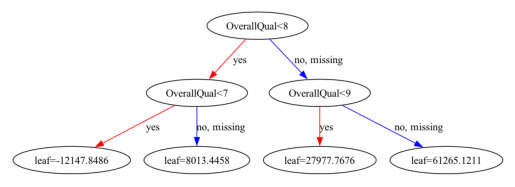

In [12]:
params = {"objective": "reg:squarederror", "max_depth": 2, "seed": 42}
model = xgb.train(params=params, dtrain=housing_DM, num_boost_round=10)

xgb.plot_tree(model, num_trees=0)
plt.show()


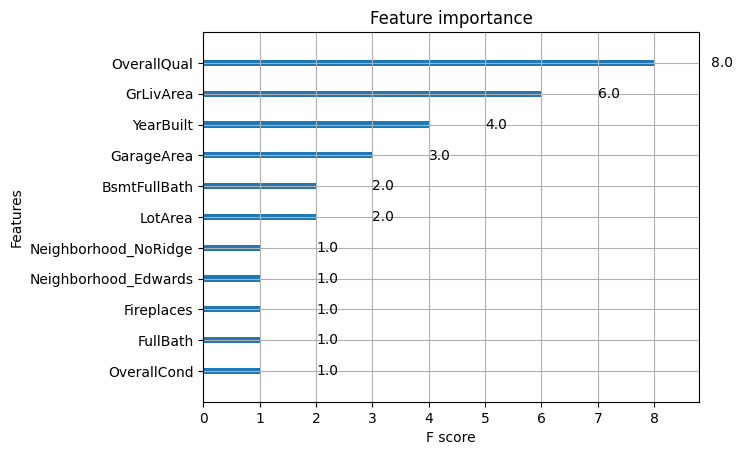

In [13]:
xgb.plot_importance(model)
plt.show()


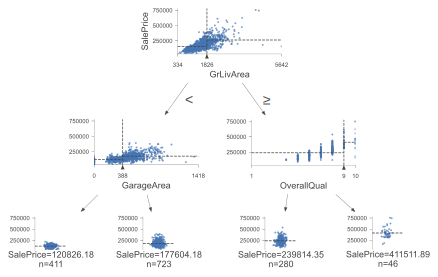

In [14]:
viz = dtreeviz.model(
    model,
    housing_X,
    housing_y,
    tree_index=3,
    target_name="SalePrice",
    feature_names=housing_X.columns.to_list(),
)
viz.view()


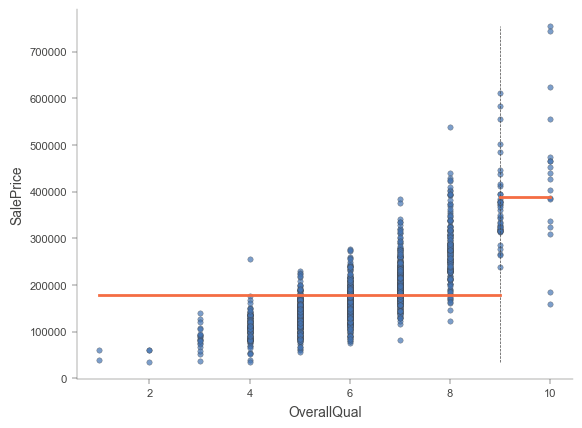

In [15]:
viz.rtree_feature_space(
    show={"splits"},
    features=["OverallQual"],
)


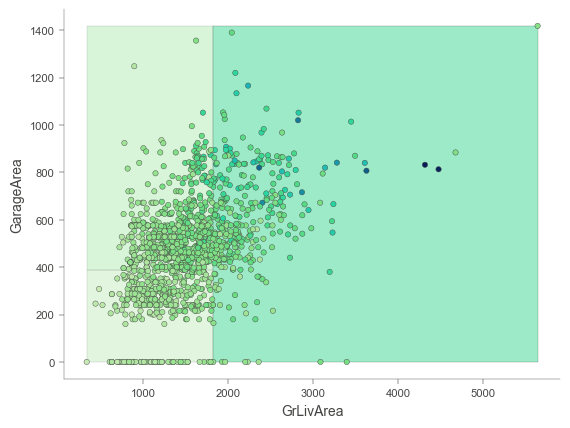

In [16]:
viz.rtree_feature_space(
    show={"splits"},
    features=["GrLivArea", "GarageArea"],
)


## Hyperparameter Tuning

Common tunable hyperparameters are:
- `eta`: step-size shrinkage to prevent overfitting (aka `learning_rate`)
  * default: `0.3`
- `gamma`: minimum loss reduction required to make a further partition (aka `min_split_loss`)
  * default: `0`
- `lambda`: L2 regularization term on weights (aka `reg_lambda`)
  * default: `1`
- `alpha`: L1 regularization term on weights (aka `reg_alpha`)
  * default: `0`
- `max_depth`: maximum depth of a tree
  * default: `6`
- `subsample`: subsample ratio of the training instances
  * default: `1`
- `colsample_bytree`: subsample ratio of columns when constructing each tree
  * default: `1`

In [17]:
housing_X, housing_y = ames_housing.iloc[:, :-1], ames_housing.iloc[:, -1]
housing_DM = xgb.DMatrix(data=housing_X, label=housing_y)

params = {"objective": "reg:squarederror", "max_depth": 3, "seed": 42}
num_rounds = [5, 10, 15]
final_rmse_per_round = []

for curr_num_rounds in num_rounds:
    cv_results = xgb.cv(
        dtrain=housing_DM,
        params=params,
        nfold=3,
        num_boost_round=curr_num_rounds,
        metrics="rmse",
        as_pandas=True,
        seed=42,
    )
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# more rounds increases RMSE
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
result = pd.DataFrame(num_rounds_rmses, columns=["num_boosting_rounds", "rmse"])
result


,num_boosting_rounds,rmse
0,5,41174.223701
1,10,36687.380085
2,15,35982.696985


In [18]:
eta_vals = [0.001, 0.01, 0.1]
best_rmse = []
for val in eta_vals:
    params["eta"] = val
    cv_results = xgb.cv(
        dtrain=housing_DM,
        params=params,
        nfold=3,
        num_boost_round=10,
        early_stopping_rounds=5,
        metrics="rmse",
        as_pandas=True,
        seed=42,
    )
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

result = pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta", "best_rmse"])
result


,eta,best_rmse
0,0.001,78718.689865
1,0.010,74141.772830
2,0.100,47729.585334


In [19]:
max_depths = [2, 5, 10, 20]
best_rmse = []
for md in max_depths:
    params["max_depth"] = md
    cv_results = xgb.cv(
        dtrain=housing_DM,
        params=params,
        nfold=2,
        num_boost_round=10,
        early_stopping_rounds=5,
        metrics="rmse",
        as_pandas=True,
        seed=42,
    )
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

result = pd.DataFrame(list(zip(max_depths, best_rmse)), columns=["max_depth", "best_rmse"])
result


,max_depth,best_rmse
0,2,50011.393928
1,5,45047.595592
2,10,44979.266825
3,20,45113.479156


In [20]:
colsample_bytree_vals = [0.1, 0.5, 0.8, 1]
best_rmse = []
for val in colsample_bytree_vals:
    params["colsample_bytree"] = val
    cv_results = xgb.cv(
        dtrain=housing_DM,
        params=params,
        nfold=2,
        num_boost_round=10,
        early_stopping_rounds=5,
        metrics="rmse",
        as_pandas=True,
        seed=42,
    )
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

result = pd.DataFrame(
    list(zip(colsample_bytree_vals, best_rmse)),
    columns=["colsample_bytree", "best_rmse"],
)
result


,colsample_bytree,best_rmse
0,0.1,63746.960116
1,0.5,43860.415190
2,0.8,44035.817044
3,1.0,45113.479156


### Grid Search and Random Search

_Grid search_ is a brute-force method of hyperparameter tuning that exhaustively searches through a specified subset of the hyperparameter space. If you have 2 hyperparameters with 4 possible values each, then grid search will have to train and evaluate 16 models.

_Random search_ draws a set number of samples from the specified hyperparameter space.

In [21]:
housing_X, housing_y = ames_housing.iloc[:, :-1], ames_housing.iloc[:, -1]

model = xgb.XGBRegressor()

param_grid = {
    "colsample_bytree": [0.3, 0.7],
    "n_estimators": [50],
    "max_depth": [2, 5],
}

grid_search = GridSearchCV(
    param_grid=param_grid,
    estimator=model,
    scoring="neg_mean_squared_error",
    cv=4,
)
grid_search.fit(housing_X, housing_y)

print(f"Lowest RMSE: {np.sqrt(np.abs(grid_search.best_score_)):.4f}")
print("Best params:")
for k, v in grid_search.best_params_.items():
    print(f"  {k} -> {v}")


Lowest RMSE: 30186.0796
Best params:
  colsample_bytree -> 0.7
  max_depth -> 2
  n_estimators -> 50


In [22]:
model = xgb.XGBRegressor()

param_grid = {
    "n_estimators": [25],
    "max_depth": range(2, 12),
}

random_search = RandomizedSearchCV(
    param_distributions=param_grid,
    estimator=model,
    scoring="neg_mean_squared_error",
    n_iter=5,
    cv=4,
)
random_search.fit(housing_X, housing_y)

print(f"Lowest RMSE: {np.sqrt(np.abs(random_search.best_score_)):.4f}")
print("Best params:")
for k, v in random_search.best_params_.items():
    print(f"  {k} -> {v}")


Lowest RMSE: 31369.1234
Best params:
  n_estimators -> 25
  max_depth -> 3


## Pipelines

In [23]:
# custom Dictifier transformer
class Dictifier(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # if a dataframe
        if isinstance(X, pd.DataFrame):
            return X.to_dict("records")
        # otherwise a ndarray
        else:
            return pd.DataFrame(X).to_dict("records")


# chronic kidney disease dataset
X, y = kidney_disease.iloc[:, :-1], kidney_disease.iloc[:, -1]

# label encode target
y = LabelEncoder().fit_transform(y)

# divide by column types
cat_mask = X.dtypes == object
cat_cols = X.columns[cat_mask].tolist()
num_cols = X.columns[~cat_mask].tolist()  # the `~` means "not"

# numeric impute using median value of column
num_mapper = DataFrameMapper(
    [([num_col], SimpleImputer(strategy="median")) for num_col in num_cols],
    input_df=True,
    df_out=True,
)

# categorical impute using mode (most frequent)
cat_mapper = DataFrameMapper(
    [(cat_cols, SimpleImputer(strategy="most_frequent"))],
    input_df=True,
    df_out=True,
)

# combine numeric and categorical transforms
num_cat_union = FeatureUnion(
    transformer_list=[("num_mapper", num_mapper), ("cat_mapper", cat_mapper)]
)

# create pipeline
pipeline = Pipeline(
    [
        ("num_cat_union", num_cat_union),
        ("dictifier", Dictifier()),
        ("vectorizer", DictVectorizer(sort=False)),
        ("clf", xgb.XGBClassifier(max_depth=3)),
    ]
)

# hyperparameter grid
clf_param_grid = {
    "clf__learning_rate": np.arange(0.05, 1, 0.05),
    "clf__max_depth": np.arange(3, 10, 1),
    "clf__n_estimators": np.arange(50, 200, 50),
}

# random search
rand_roc_auc = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=clf_param_grid,
    scoring="roc_auc",
    n_iter=2,
    cv=2,
)
rand_roc_auc.fit(X, y)

# best score and best params
print(f"Best score: {rand_roc_auc.best_score_:.4f}")
print("Best params:")
for k, v in rand_roc_auc.best_params_.items():
    print(f"  {k[5:]} -> {v}")


Best score: 0.9982
Best params:
  n_estimators -> 100
  max_depth -> 4
  learning_rate -> 0.05
